## Content
1. Imports and data exploration - (you can skip this)
2. Create the dataset - per each timeframe (each 10 seconds) a matrix (in frequency domain) of shape 32 (channels) * 4 (features the means of each EEG band) gets extracted. Resulting in 6 matrices per video per participant (60 seconds in total) and 240 matrices in total per participant ie. 40 videos * 6 matrices.
3. Extract Labels - here I reconstructed the binary labels, every label gets rounded to 0 if <=5 or 1 if >5
4. Normalize Data - stratified normalization as before.

## 1. Imports and data exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew,kurtosis
import pandas as pd
from numpy.fft import fft, ifft

In [3]:
#this is a dict
raw_data = np.load('data/data_preprocessed_python/s01.dat',allow_pickle=True,encoding='bytes')

In [4]:
raw_data.keys()

dict_keys([b'labels', b'data'])

In [5]:
data = raw_data[b'data']
labels = raw_data[b'labels']

In [6]:
#valance, arousal, dominance, liking
labels[0]

array([7.71, 7.6 , 6.9 , 7.83])

In [7]:
data.shape #shape of data in (video/trial x channel x data) 40 layers, 40 rows, and 8064 columns

(40, 40, 8064)

In [8]:
data[0][0][0] #check an element

0.948231680995192

In [9]:
labels.shape #shape of the labels

(40, 4)

In [10]:
# experiment 1 first eeg channel
data[0][0]
# experiment 1 second eeg channel
# data[b'data'][0][1] 

array([ 0.94823168,  1.65333533,  3.01372577, ..., -2.82648937,
       -4.47722969, -3.67692812])

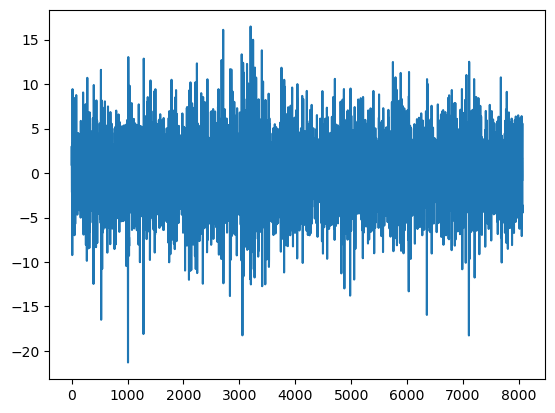

In [10]:
visu = data[0][0]
plt.plot(visu)

In [17]:
len(np.abs(freq))

8064

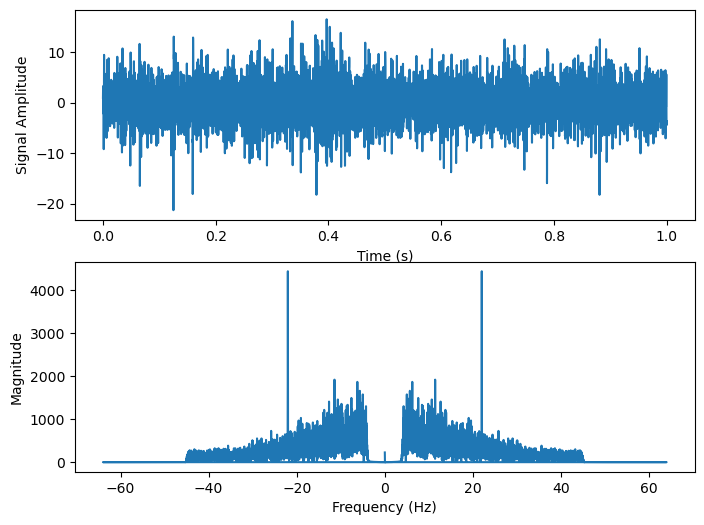

In [11]:
# Perform FFT
fft = np.fft.fft(visu)

# Calculate corresponding frequencies
freqs = np.fft.fftfreq(len(visu), d=1/128)

# Plot the signal in time and frequency domain
t = np.arange(0,1,(1/8064))
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(t, visu)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal Amplitude')
ax[1].plot(freqs, np.abs(fft))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Magnitude')

plt.show()

In [12]:
freqs.shape

(8064,)

In [13]:
np.abs(fft).shape

(8064,)

In [14]:
len(freqs)

8064

## 2. Create the dataset 

In [11]:
num_trials = 40
num_channel = 32

In [40]:
# this method extracts the mean feature in frequency domain for each EEG band
def getfeatures(arr):
    # Perform FFT
    fft = np.fft.fft(arr)
    # Calculate corresponding frequencies
    freqs = np.fft.fftfreq(len(arr), d=1/128)
    return get_bands(fft,freqs)

In [35]:
# Extracts the corresponding frequencies 
def get_bands(fft,frequency):
    #t = np.arange(0,1,(1/8064))
    theta = []
    alpha = []
    beta = []
    gamma = []
    for i in range(len(frequency)):
        if frequency[i] > 4 and frequency[i] < 7:
            theta.append(np.abs(fft[i]))
        if frequency[i] > 8 and frequency[i] < 12:
            alpha.append(np.abs(fft[i]))
        if frequency[i] > 13 and frequency[i] < 30:
            beta.append(np.abs(fft[i]))
        if frequency[i] > 30 and frequency[i] < 50:
            gamma.append(np.abs(fft[i]))
    return np.mean(theta), np.mean(alpha), np.mean(beta), np.mean(gamma)

In [65]:
# the same looping approach is used here as in the previous work from Bhat, the only difference is the underlying
# feature extracting in the frequency domain on the EEG bands
def makeonefile2(fname):
    threed = np.zeros((40,32,44))
    threed[:] = np.nan
    print("Reading the data from the directory..")     
    f = open(fname, 'rb')                 #Read the file in Binary mode
    x = np.load(f,allow_pickle=True,encoding='bytes')

    for tr in range(num_trials):
        newfile = np.array([]).reshape(0,44)
        for ch in range(num_channel):
            empty_array = np.array([])
            for i in range(10):
                f = getfeatures(x[b'data'][tr][ch][807*i:807*(i+1)])
                empty_array = np.append(empty_array, f)
                if i== 9:
                    empty_array = np.append(empty_array,getfeatures(x[b'data'][tr][ch][:]))
            #print(newfile.shape)
            #print(empty_array.shape)
            newfile = np.vstack((newfile, empty_array))
        threed[tr][:][:]=newfile      
    print("Data processed")
    print("shape of file:",threed.shape)
#     print(newfile)
    return threed

In [66]:
# Test with one file
name = "01"
fname = "data/data_preprocessed_python/s"+str(name)+".dat"  
test = makeonefile2(fname)
# End test

Reading the data from the directory..
Data processed
shape of file: (40, 32, 44)


In [73]:
## from Bhat

#method 1 step 2
#Pipeline to get the data 
# takes in the number of test subjects as input
def callpipeline(num_testsub):
    for i in range(num_testsub):
            if i < 10:
                name = '%0*d' % (2,i+1)
            else:
                name = i+1
            fname = "data/data_preprocessed_python/s"+str(name)+".dat"  
            print("\n")
            print("Test Subject ------",name)
            outputfile = makeonefile2(fname)
            np.save(str(name), outputfile)

In [75]:
num_testsub = 32
callpipeline(num_testsub)



Test Subject ------ 01
Reading the data from the directory..
Data processed
shape of file: (40, 32, 44)


Test Subject ------ 02
Reading the data from the directory..
Data processed
shape of file: (40, 32, 44)


Test Subject ------ 03
Reading the data from the directory..
Data processed
shape of file: (40, 32, 44)


Test Subject ------ 04
Reading the data from the directory..
Data processed
shape of file: (40, 32, 44)


Test Subject ------ 05
Reading the data from the directory..
Data processed
shape of file: (40, 32, 44)


Test Subject ------ 06
Reading the data from the directory..
Data processed
shape of file: (40, 32, 44)


Test Subject ------ 07
Reading the data from the directory..
Data processed
shape of file: (40, 32, 44)


Test Subject ------ 08
Reading the data from the directory..
Data processed
shape of file: (40, 32, 44)


Test Subject ------ 09
Reading the data from the directory..
Data processed
shape of file: (40, 32, 44)


Test Subject ------ 10
Reading the data from

In [81]:
# Loads the saved numpy files that are saved into a dictionary
def loadfiles():
    data_dict = {}
    print("Loading files into data_dict .................")
    for i in range(num_testsub):
                    if i < 10:
                        name = '%0*d' % (2,i+1)
                    else:
                        name = i+1
                    fname = 'data/data_prepared/data_stft/'+str(name) +'.npy'
    #                 print(fname)
                    data_dict["sub%s" %name] = np.load(fname)
    print("Loaded!!!!!") 
    return data_dict

In [82]:
data_dict = loadfiles()

Loading files into data_dict .................
Loaded!!!!!


In [83]:
data_dict["sub01"].shape

(40, 32, 44)

----

## 3. Extract Labels - same as before

In [22]:
def turn_into_binary(recorded_value):
    if recorded_value <= 5: 
        return 0
    else:
        return 1

In [23]:
# 0 = Valance; 1 = Arousal; 2 = Dominance; 3 = Liking
index = [0, 1, 2, 3]

for ind in index: 
    binary_labels = []
    for i in range(num_testsub):

                if i < 10:
                    name = '%0*d' % (2,i+1)
                else:
                    name = i+1
                # Read in labels of file
                labels = np.load('data/data_preprocessed_python/s'+str(name)+'.dat',allow_pickle=True,encoding='bytes')[b'labels']
                # Temp variable
                rounded_labels = np.empty(40)
                # round the values and save them
                for j in range(labels.shape[0]):
                    binary_value = turn_into_binary(labels[j][ind])
                    rounded_labels[j] = binary_value
                # Append to global list
                binary_labels = np.append(binary_labels, rounded_labels,axis=0) 

    np.save('data/data_prepared/labels/label_class_'+str(ind)+'.npy', binary_labels)            
            

In [28]:
binary_labels.shape

(1280,)

In [ ]:
#Load the labels now    
valence = np.load('data/data_prepared/labels/label_class_0.npy')
arousal = np.load('data/data_prepared/labels/label_class_1.npy')
dominance = np.load('data/data_prepared/labels/label_class_2.npy')
liking = np.load('data/data_prepared/labels/label_class_3.npy')

In [ ]:
test = arousal[440:480]
print(len(test))
print(test)

In [ ]:
labels2 = np.load('data/data_preprocessed_python/s12.dat',allow_pickle=True,encoding='bytes')[b'labels']
labels2

## 4. Normalize Data 

In [84]:
num_videos = 40
num_channels = 32
num_features = 44

counter = 0
for sub in data_dict.keys():
    for i in range(num_channels):
        for j in range(num_features):
            channel_values = []
            # data_dict[video][channel][44 data]
            # [0][0][0] --> [1][0][0] --> [2][0][0] .... [0][0][1] --> [1][0][1] --> [2][0][1]
            # .... ---> [0][0][44] --> [0][1][0] --> [1][1][0]
            for k in range(num_videos):
                channel_values.append(data_dict[sub][k][i][j])
            # get min and max
            min_channel = np.min(channel_values)
            max_channel = np.max(channel_values)
            # go over each value one more time and normalize it
            for l in range(num_videos):
                x = data_dict[sub][l][i][j] 
                data_dict[sub][l][i][j] = (x - min_channel) / (max_channel - min_channel)
                if counter <= 40:
                    print(" original ",x)
                    print(" new ",data_dict[sub][l][i][j], " k ",l, " i ",i," j ",j)
                counter = counter + 1
            channel_values.clear()

 original  166.75920194734766
 new  0.08907232874956247  k  0  i  0  j  0
 original  256.72039924960154
 new  0.48672586340195695  k  1  i  0  j  0
 original  372.83845642468447
 new  1.0  k  2  i  0  j  0
 original  274.61133422750817
 new  0.5658087763193741  k  3  i  0  j  0
 original  207.84524148144504
 new  0.27068406064669354  k  4  i  0  j  0
 original  265.0385159111524
 new  0.5234942545673533  k  5  i  0  j  0
 original  360.5703743870188
 new  0.9457716623168921  k  6  i  0  j  0
 original  283.172170182047
 new  0.6036500543257572  k  7  i  0  j  0
 original  250.6463258537111
 new  0.4598767681470476  k  8  i  0  j  0
 original  177.584499529889
 new  0.1369231575118619  k  9  i  0  j  0
 original  259.430850818331
 new  0.4987068138464926  k  10  i  0  j  0
 original  279.834299785191
 new  0.5888957380057794  k  11  i  0  j  0
 original  366.90502170559125
 new  0.9737725668462447  k  12  i  0  j  0
 original  158.85027568519402
 new  0.05411267305618776  k  13  i  0  j

In [85]:
data_dict['sub01'].shape

(40, 32, 44)

In [86]:
#safe noramlized data
for sub in data_dict.keys():
    np.save('data/data_prepared/data_norm_stft/noramlized_data'+sub, data_dict.get(sub))